In [3]:
# Package importieren
import pickle
import joblib
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, make_scorer, roc_curve, auc, f1_score, recall_score, precision_score

In [4]:
# Daten importieren
X_train = pd.read_csv("../../Resampling/X_train.csv", index_col=0)
X_test = pd.read_csv("../../Resampling/X_test.csv", index_col=0)
X_val = pd.read_csv("../../Resampling/X_val.csv", index_col=0)

X_train_ros = pd.read_csv("../../Resampling/X_train_ros.csv", index_col=0)
X_test_ros = pd.read_csv("../../Resampling/X_test_ros.csv", index_col=0)
X_val_ros = pd.read_csv("../../Resampling/X_val_ros.csv", index_col=0)

X_train_stm = pd.read_csv("../../Resampling/X_train_stm.csv", index_col=0)
X_test_stm = pd.read_csv("../../Resampling/X_test_stm.csv", index_col=0)
X_val_stm = pd.read_csv("../../Resampling/X_val_stm.csv", index_col=0)

y_train = pd.read_csv("../../Resampling/y_train.csv", index_col=0)
y_train_ros = pd.read_csv("../../Resampling/y_train_ros.csv", index_col=0)
y_train_stm = pd.read_csv("../../Resampling/y_train_stm.csv", index_col=0)

y_test = pd.read_csv("../../Resampling/y_test.csv", index_col=0)
y_val = pd.read_csv("../../Resampling/y_val.csv", index_col=0)
print("Alle Datensätze wurden importiert.")

Alle Datensätze wurden importiert.


In [5]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_val:", X_val.shape)

print("X_train_ros:", X_train_ros.shape)
print("X_test_ros:", X_test_ros.shape)
print("X_val_ros:", X_val_ros.shape)

print("X_train_stm:", X_train_stm.shape)
print("X_test_stm:", X_test_stm.shape)
print("X_val_stm:", X_val_stm.shape)

print("y_train:", y_train.shape)
print("y_train_ros:", y_train_ros.shape)
print("y_train_stm:", y_train_stm.shape)

print("y_test:", y_test.shape)
print("y_val:", y_val.shape)

X_train: (163304, 21)
X_test: (50736, 21)
X_val: (25368, 21)
X_train_ros: (163304, 21)
X_test_ros: (50736, 21)
X_val_ros: (25368, 21)
X_train_stm: (273194, 21)
X_test_stm: (50736, 21)
X_val_stm: (25368, 21)
y_train: (163304, 1)
y_train_ros: (163304, 1)
y_train_stm: (273194, 1)
y_test: (50736, 1)
y_val: (25368, 1)


## E_MT_D_1: Entscheidungsbaum mit resampeltem Datensatz

In [92]:
# Hyperparametertuning
clf = DecisionTreeClassifier(random_state=42)

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [15,25,35,50],
    "min_samples_split": [2,5,10,15,25],
    "min_samples_leaf": [5,10,15,25],
    "max_leaf_nodes": [5,10,30,50,100,200,500,1000, 2500, 5000],
    "max_features": ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scoring = {"recall":make_scorer(recall_score, pos_label=1), "precision":make_scorer(precision_score, pos_label=1), "f1":make_scorer(f1_score, pos_label=1)}

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit="f1",
    n_jobs=-1,
    error_score='raise'
)

grid_search.fit(X_train_stm, np.ravel(y_train_stm))
results = grid_search.cv_results_

In [93]:
print("Beste gefundene Params: ", grid_search.best_params_)

Beste gefundene Params:  {'criterion': 'gini', 'max_depth': 25, 'max_features': 'sqrt', 'max_leaf_nodes': 5000, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [6]:
final_model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=25,
    max_features='sqrt',
    max_leaf_nodes=5000,
    min_samples_split=2,
    min_samples_leaf=5,
    random_state=42,
)
final_model.fit(X_train_stm, np.ravel(y_train_stm))

DecisionTreeClassifier(max_depth=25, max_features='sqrt', max_leaf_nodes=5000,
                       min_samples_leaf=5, random_state=42)

In [96]:
y_pred = final_model.predict(X_val_stm)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.76      0.83     21833
           1       0.30      0.63      0.40      3535

    accuracy                           0.74     25368
   macro avg       0.61      0.69      0.62     25368
weighted avg       0.84      0.74      0.77     25368



In [7]:
y_pred_test = final_model.predict(X_test_stm)

y_probs_test = final_model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(np.ravel(y_test), y_probs_test)
print(f"AUC-ROC: {auc_score:.4f}")

print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

AUC-ROC: 0.7582
              precision    recall  f1-score   support

           0       0.93      0.75      0.83     43667
           1       0.29      0.64      0.40      7069

    accuracy                           0.74     50736
   macro avg       0.61      0.70      0.62     50736
weighted avg       0.84      0.74      0.77     50736

[[32830 10837]
 [ 2536  4533]]


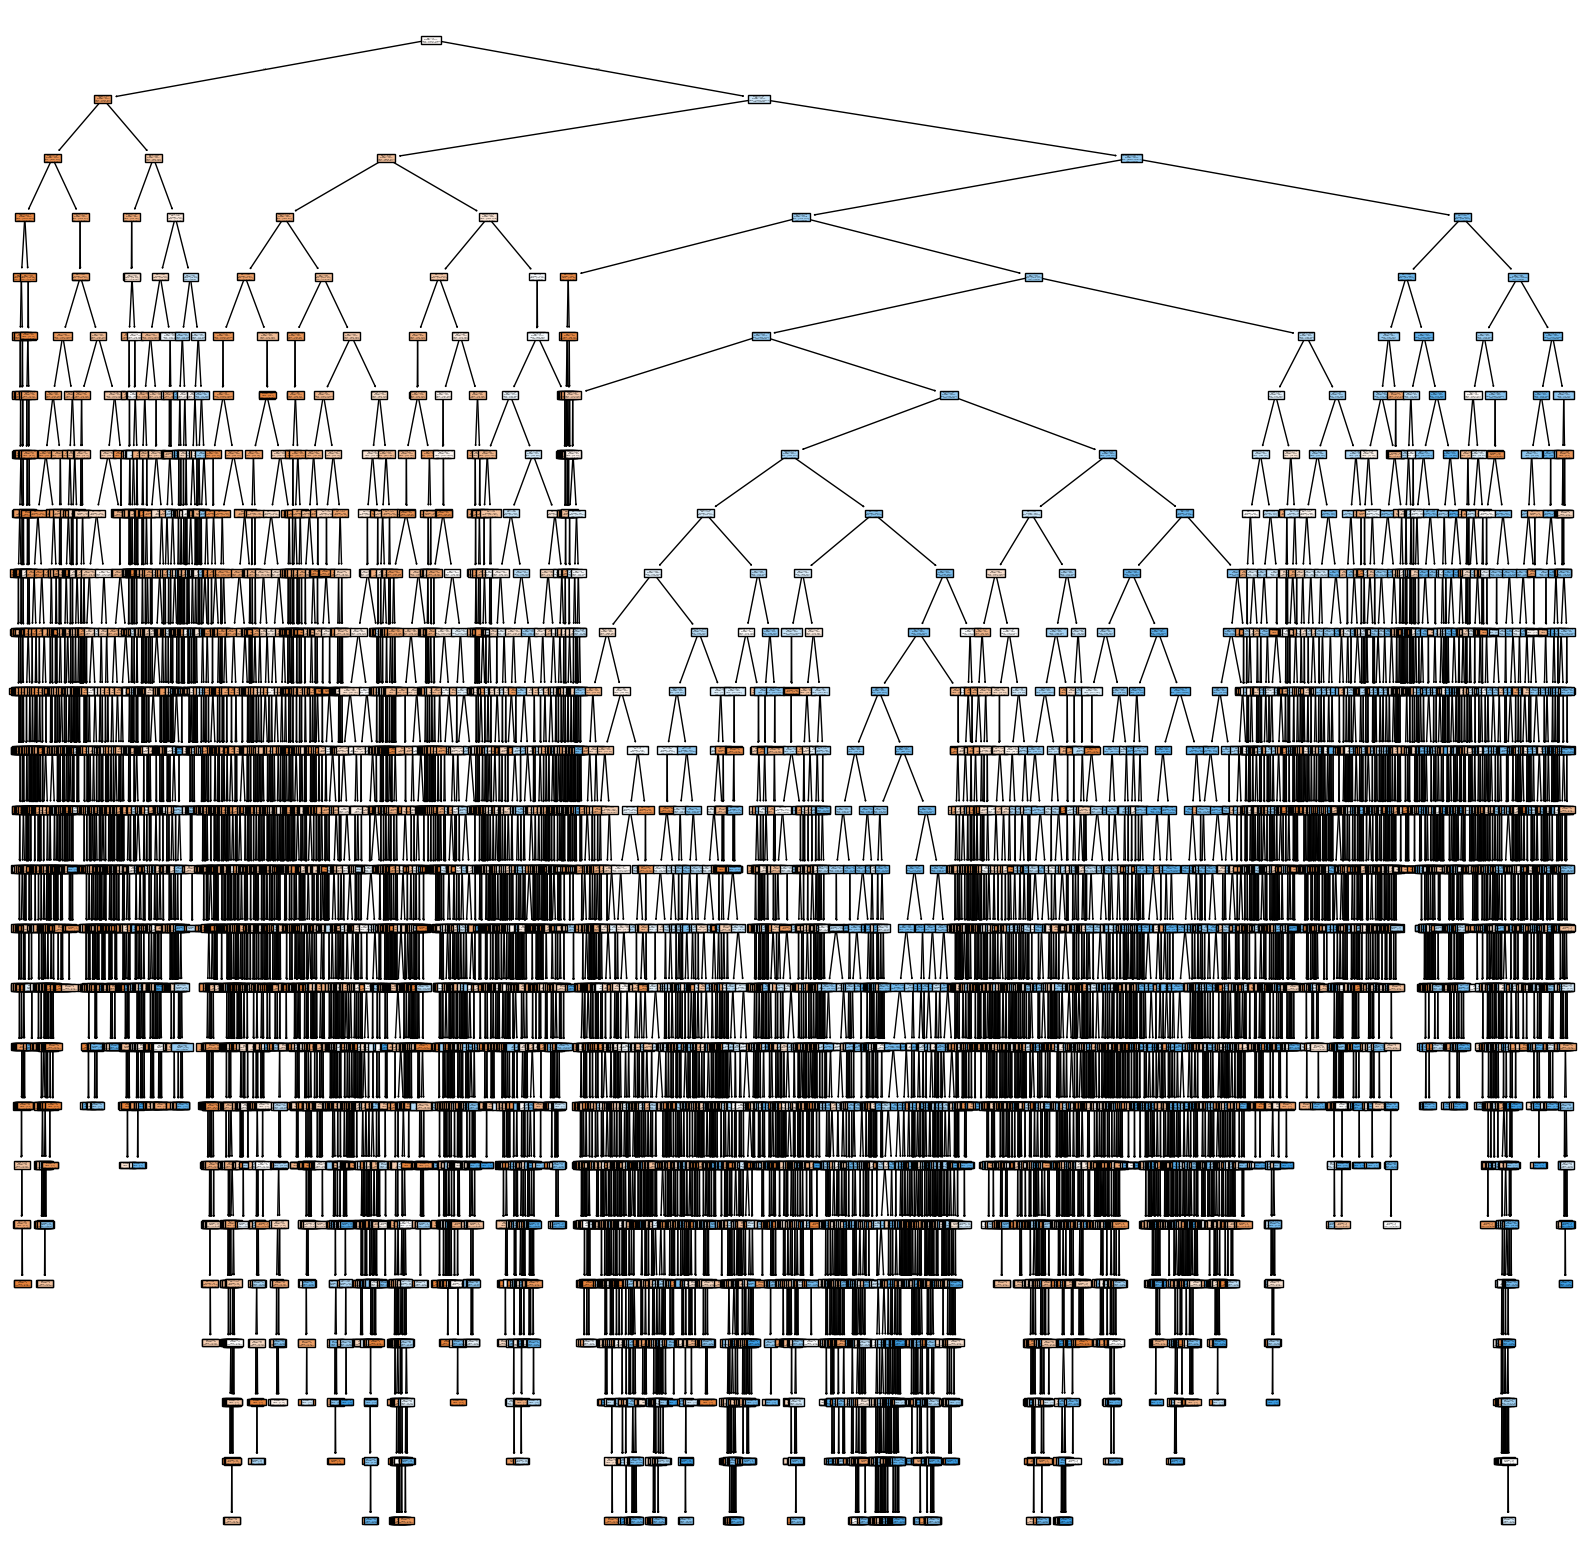

In [98]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plot_tree(final_model, feature_names=X_train_stm.columns, class_names=["Kein Diabetes", "Diabetes"], filled=True)
plt.show()

## E_MT_D_2 Entcheidungsbaum mit originärem Datensatz und angepasster 'class_weight'

In [18]:
# Hyperparametertuning
clf = DecisionTreeClassifier(random_state=42)

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [15,25,35,50],
    "min_samples_split": [2,5,10,15,25],
    "min_samples_leaf": [5,10,15,25],
    "max_leaf_nodes": [5,10,30,50,100,200,500,None],
    "max_features": ['sqrt', 'log2'],
    "class_weight": [{0:0.8,1:3},{0:1, 1:4},{0:1,1:6},{0:1,1:8},'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {"recall":make_scorer(recall_score, pos_label=1), "precision":make_scorer(precision_score, pos_label=1), "f1":make_scorer(f1_score, pos_label=1)}

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit="f1",
    n_jobs=-1,
    error_score='raise'
)

grid_search.fit(X_train, np.ravel(y_train))
results = grid_search.cv_results_

In [19]:
print("Beste gefundene Params: ", grid_search.best_params_)

Beste gefundene Params:  {'class_weight': {0: 0.8, 1: 3}, 'criterion': 'gini', 'max_depth': 25, 'max_features': 'sqrt', 'max_leaf_nodes': 200, 'min_samples_leaf': 25, 'min_samples_split': 2}


In [32]:
# Hyperparametertuning2
clf = DecisionTreeClassifier(criterion='gini', max_depth=25, max_features='sqrt', max_leaf_nodes=200, min_samples_split=2, class_weight={0:0.8, 1:3}, random_state=42)

param_grid = {
    "min_samples_leaf": [15,25,35,50,75,100]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {"recall":make_scorer(recall_score, pos_label=1), "precision":make_scorer(precision_score, pos_label=1), "f1":make_scorer(f1_score, pos_label=1)}

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit="f1",
    n_jobs=-1,
    error_score='raise'
)

grid_search.fit(X_train, np.ravel(y_train))
results = grid_search.cv_results_

In [33]:
print("Beste gefundene Params: ", grid_search.best_params_)

Beste gefundene Params:  {'min_samples_leaf': 50}


In [8]:
final_model2 = DecisionTreeClassifier(
    criterion="gini",
    max_depth=25,
    max_features='sqrt',
    max_leaf_nodes=200,
    min_samples_split=2,
    min_samples_leaf=50,
    random_state=42,
    class_weight={0:0.8, 1:3}
)
final_model2.fit(X_train, np.ravel(y_train))

DecisionTreeClassifier(class_weight={0: 0.8, 1: 3}, max_depth=25,
                       max_features='sqrt', max_leaf_nodes=200,
                       min_samples_leaf=50, random_state=42)

In [35]:
y_pred = final_model2.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87     21833
           1       0.35      0.62      0.45      3535

    accuracy                           0.79     25368
   macro avg       0.64      0.72      0.66     25368
weighted avg       0.85      0.79      0.81     25368

[[17778  4055]
 [ 1357  2178]]


In [9]:
y_pred = final_model2.predict(X_test)
y_proba = final_model2.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(np.ravel(y_test), y_proba)
print(f"AUC-ROC: {auc_score:.4f}")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

AUC-ROC: 0.8008
              precision    recall  f1-score   support

           0       0.93      0.81      0.86     43667
           1       0.34      0.61      0.44      7069

    accuracy                           0.78     50736
   macro avg       0.63      0.71      0.65     50736
weighted avg       0.85      0.78      0.80     50736

[[35310  8357]
 [ 2772  4297]]


In [5]:
joblib.dump(final_model2, 'decision_tree.pkl')

['decision_tree.pkl']

In [37]:
#Thresholdtuning
thresholds = np.linspace(0, 1, 101)
results = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    precision = precision_score(np.ravel(y_test), y_pred_t)
    recall = recall_score(np.ravel(y_test), y_pred_t)
    f1 = f1_score(np.ravel(y_test), y_pred_t)
    results.append((t, precision, recall, f1))

df = pd.DataFrame(results, columns=["threshold","precision","recall","f1"])
print(df.sort_values("f1", ascending=False).head())

    threshold  precision    recall        f1
50       0.50   0.339576  0.607865  0.435735
51       0.51   0.341614  0.601075  0.435638
52       0.52   0.346444  0.585656  0.435354
53       0.53   0.348661  0.578158  0.434995
54       0.54   0.353384  0.564295  0.434603


C:\Users\haihu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\haihu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\haihu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

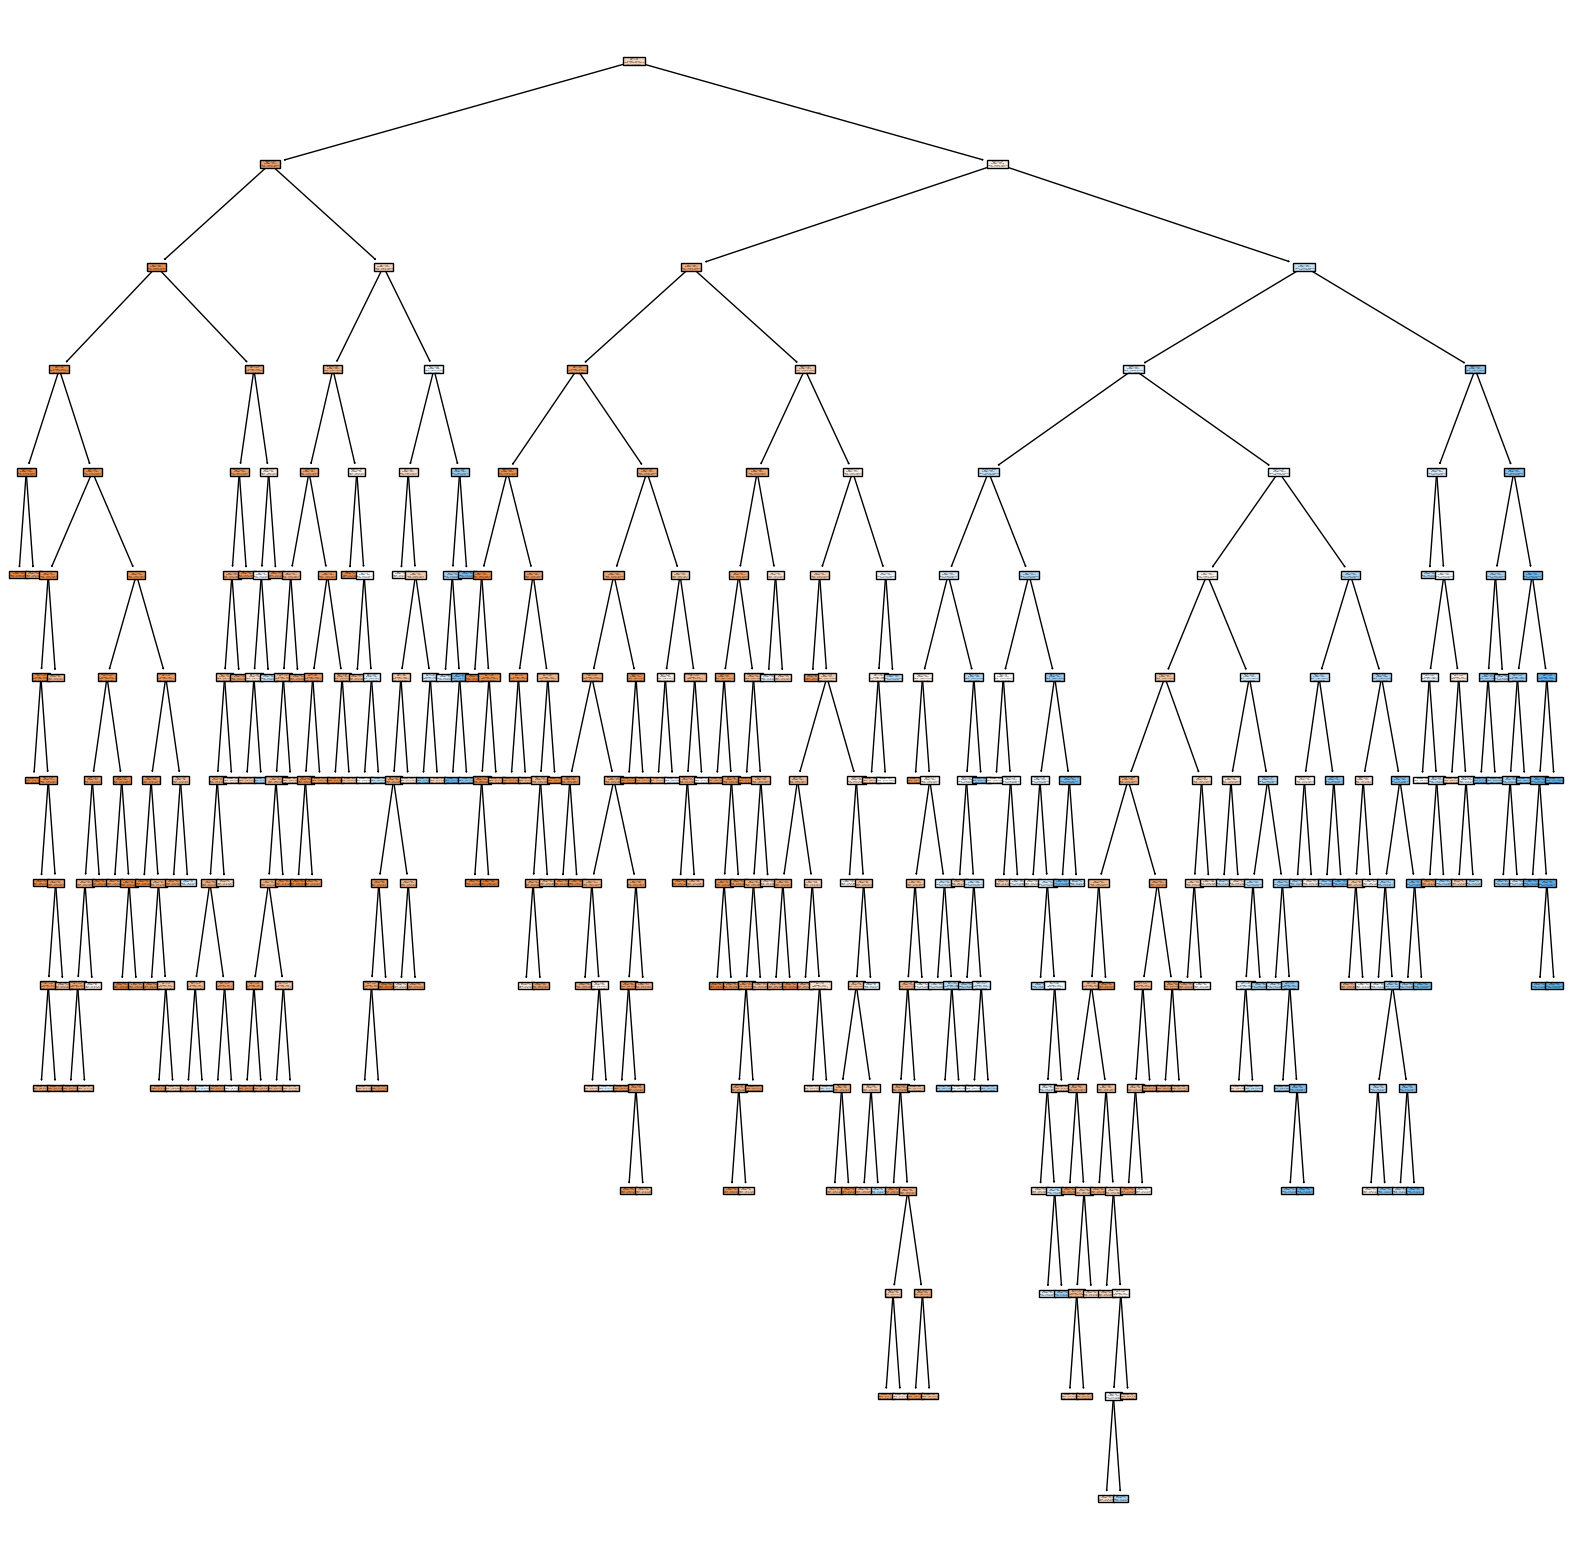

In [38]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plot_tree(final_model2, feature_names=X_train.columns, class_names=["Kein Diabetes", "Diabetes"], filled=True)
plt.show()

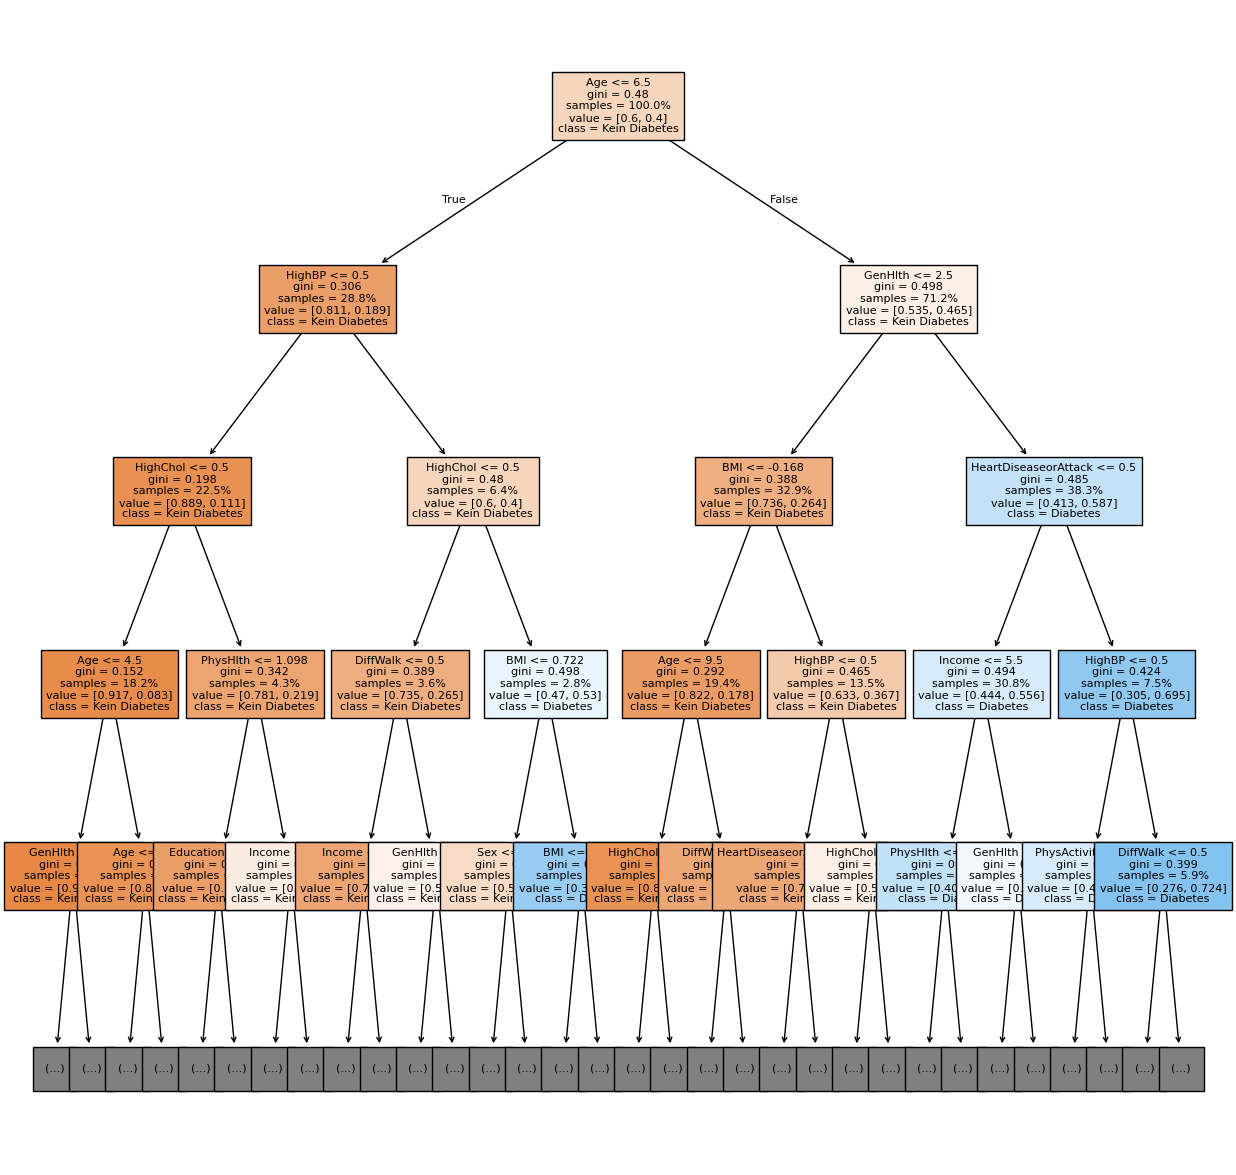

In [49]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
plot_tree(final_model2, feature_names=X_train.columns, class_names=["Kein Diabetes", "Diabetes"], filled=True, max_depth=4, fontsize=8, proportion=True)
plt.show()

In [59]:
base_clf = DecisionTreeClassifier(random_state=42)
base_clf.fit(X_train, np.ravel(y_train))

path = base_clf.cost_complexity_pruning_path(X_train, np.ravel(y_train))
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf.fit(X_train, np.ravel(y_train))
    clfs.append(clf)

clfs = clfs[1:]
ccp_alphas = ccp_alphas[1:]

In [61]:
alpha_scores = []
for clf, alpha in zip(clfs, ccp_alphas):
    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='f1', n_jobs=-1, verbose=3 )
    alpha_scores.append((alpha, np.mean(scores), np.std(scores)))

# Sortiere nach mittlerem F1 absteigend
alpha_scores = sorted(alpha_scores, key=lambda x: x[1], reverse=True)
best_alpha, best_mean, best_std = alpha_scores[0]
print(f"Bestes α = {best_alpha:.5f} mit F1 = {best_mean:.3f} ± {best_std:.3f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3

Bestes α = 0.00001 mit F1 = 0.313 ± 0.002


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished


In [62]:
final_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
final_clf.fit(X_train, np.ravel(y_train))

y_pred = final_clf.predict(X_test)
print(classification_report(np.ravel(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     43667
           1       0.40      0.24      0.30      7069

    accuracy                           0.84     50736
   macro avg       0.64      0.59      0.61     50736
weighted avg       0.82      0.84      0.83     50736



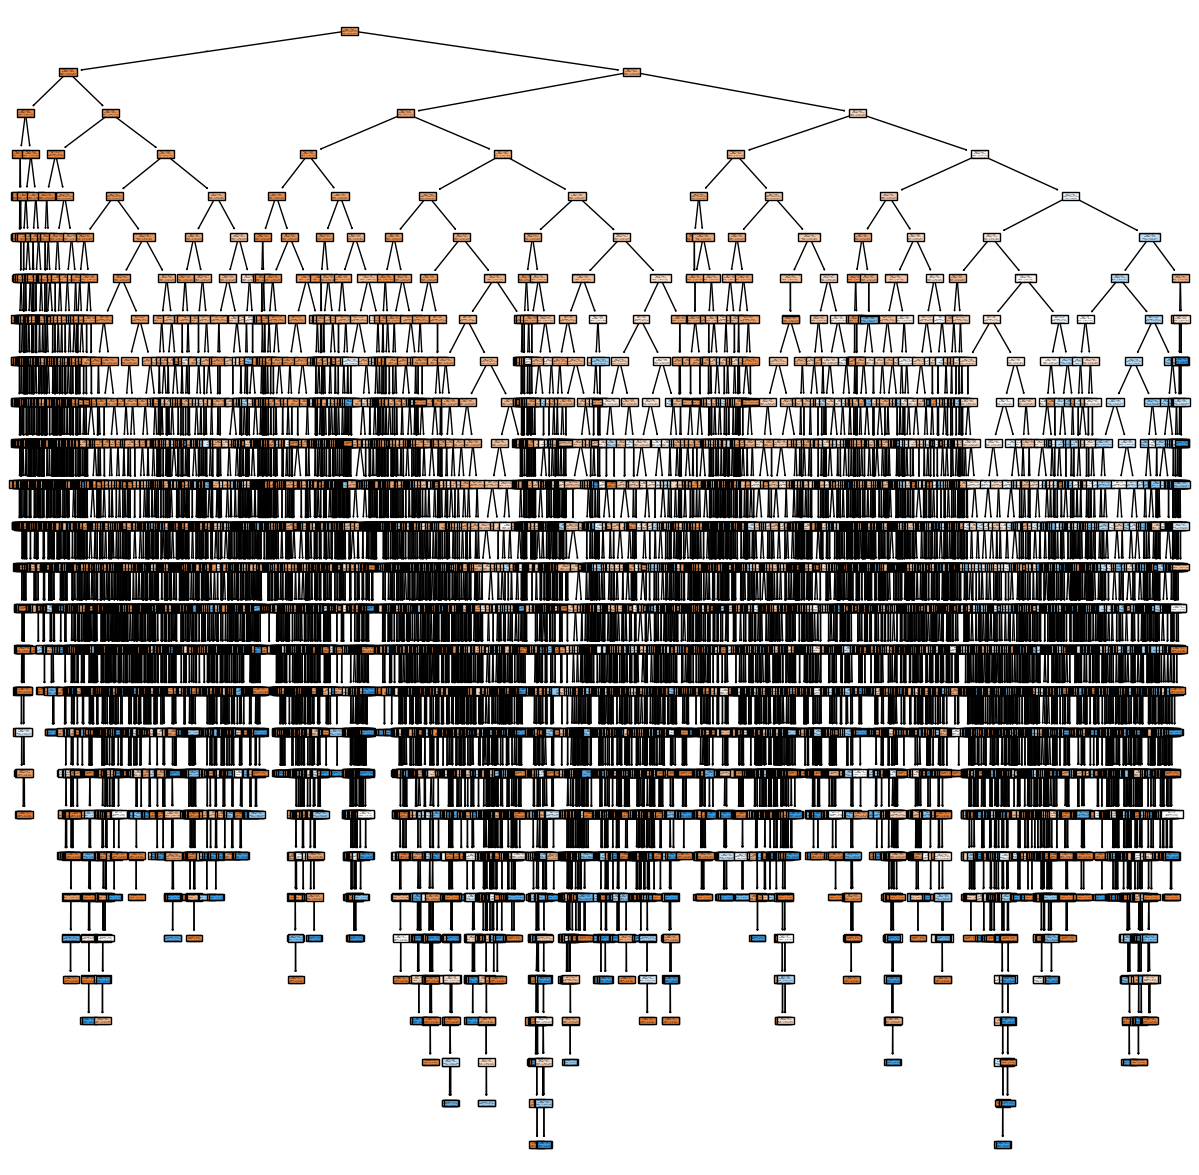

In [63]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
plot_tree(final_clf, feature_names=X_train.columns, class_names=["Kein Diabetes", "Diabetes"], filled=True, proportion=True)
plt.show()

In [85]:
final_model3 = DecisionTreeClassifier(
    criterion="gini",
    max_depth=25,
    max_features='sqrt',
    max_leaf_nodes=200,
    min_samples_split=2,
    min_samples_leaf=50,
    random_state=42,
    class_weight={0:0.8, 1:3},
    ccp_alpha=0.0019
)
final_model3.fit(X_train, np.ravel(y_train))

DecisionTreeClassifier(ccp_alpha=0.0019, class_weight={0: 0.8, 1: 3},
                       max_depth=25, max_features='sqrt', max_leaf_nodes=200,
                       min_samples_leaf=50, random_state=42)

In [86]:
y_pred = final_model3.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.68      0.79     21833
           1       0.27      0.73      0.39      3535

    accuracy                           0.69     25368
   macro avg       0.60      0.71      0.59     25368
weighted avg       0.85      0.69      0.73     25368

[[14787  7046]
 [  942  2593]]


In [76]:
y_pred = final_model3.predict(X_test)
y_proba = final_model3.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.68      0.79     43667
           1       0.27      0.74      0.39      7069

    accuracy                           0.68     50736
   macro avg       0.60      0.71      0.59     50736
weighted avg       0.85      0.68      0.73     50736

[[29500 14167]
 [ 1861  5208]]


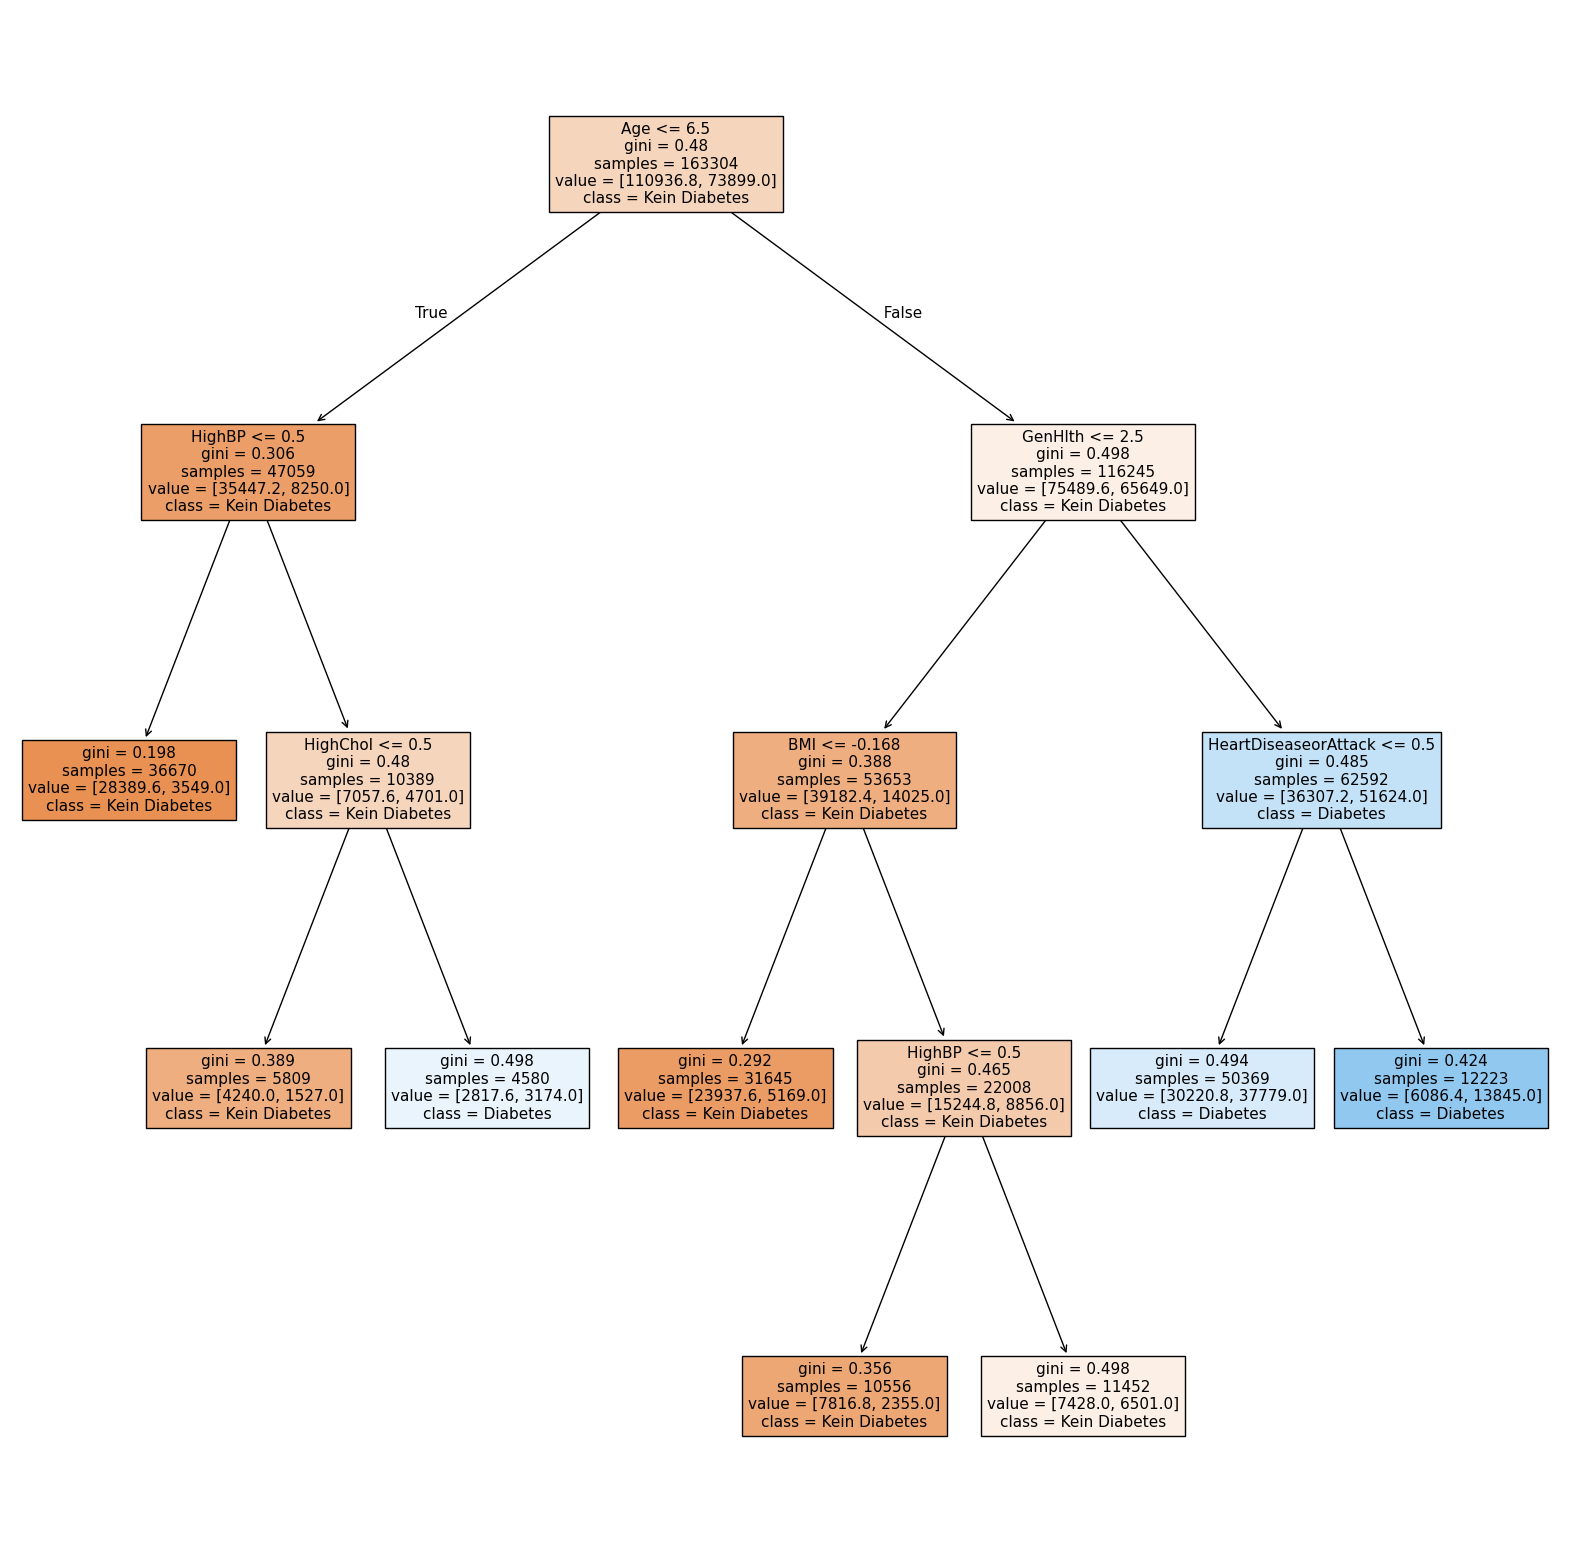

In [77]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plot_tree(final_model3, feature_names=X_train.columns, class_names=["Kein Diabetes", "Diabetes"], filled=True)
plt.show()

## E_MT_D_3: Entscheidungsbaum mit originärem Datensatz

In [87]:
# Hyperparametertuning
clf = DecisionTreeClassifier(random_state=42)

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [15,25,35,50],
    "min_samples_split": [2,5,10,15,25],
    "min_samples_leaf": [5,10,15,25],
    "max_leaf_nodes": [5,10,30,50,100,200,500,None],
    "max_features": ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {"recall":make_scorer(recall_score, pos_label=1), "precision":make_scorer(precision_score, pos_label=1), "f1":make_scorer(f1_score, pos_label=1)}

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit="f1",
    n_jobs=-1,
    error_score='raise'
)

grid_search.fit(X_train, np.ravel(y_train))
results = grid_search.cv_results_

In [88]:
print("Beste gefundene Params: ", grid_search.best_params_)

Beste gefundene Params:  {'criterion': 'entropy', 'max_depth': 35, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [10]:
final_model4 = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=35,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_samples_split=2,
    min_samples_leaf=5,
    random_state=42
)
final_model4.fit(X_train, np.ravel(y_train))

DecisionTreeClassifier(criterion='entropy', max_depth=35, max_features='sqrt',
                       min_samples_leaf=5, random_state=42)

In [90]:
y_pred = final_model4.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92     21833
           1       0.43      0.21      0.29      3535

    accuracy                           0.85     25368
   macro avg       0.66      0.58      0.60     25368
weighted avg       0.82      0.85      0.83     25368

[[20831  1002]
 [ 2777   758]]


In [11]:
y_pred = final_model4.predict(X_test)
y_proba = final_model4.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(np.ravel(y_test), y_proba)
print(f"AUC-ROC: {auc_score:.4f}")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

AUC-ROC: 0.7251
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     43667
           1       0.40      0.20      0.27      7069

    accuracy                           0.85     50736
   macro avg       0.64      0.58      0.59     50736
weighted avg       0.81      0.85      0.82     50736

[[41537  2130]
 [ 5631  1438]]
